## Idea
The purpose of this notebook is to explain the procedure of dividing the given large image with any shape, into multiple 256x256 fixed sized images, which can be further used to train a model with fixed input size. 

After dividing the given image into multiple smaller images, there will be many images which has very small details or in many cases no details (fully white image), we'll discard those images as they are not useful for training models.

In [1]:
!pip install iterative-stratification

In [2]:
import os

import math
import openslide
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from PIL import Image, ImageChops

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
BASE_DIR = '/kaggle/input/prostate-cancer-grade-assessment'
DATA_DIR = os.path.join(BASE_DIR, 'train_images')

In [4]:
%%time
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))
sample_sub_df = pd.read_csv(os.path.join(BASE_DIR, 'sample_submission.csv'))

CPU times: user 27.3 ms, sys: 10.2 ms, total: 37.5 ms
Wall time: 53.9 ms


In [5]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


Let's first read and visualize the training image which we are going to use as an example in this notebook.

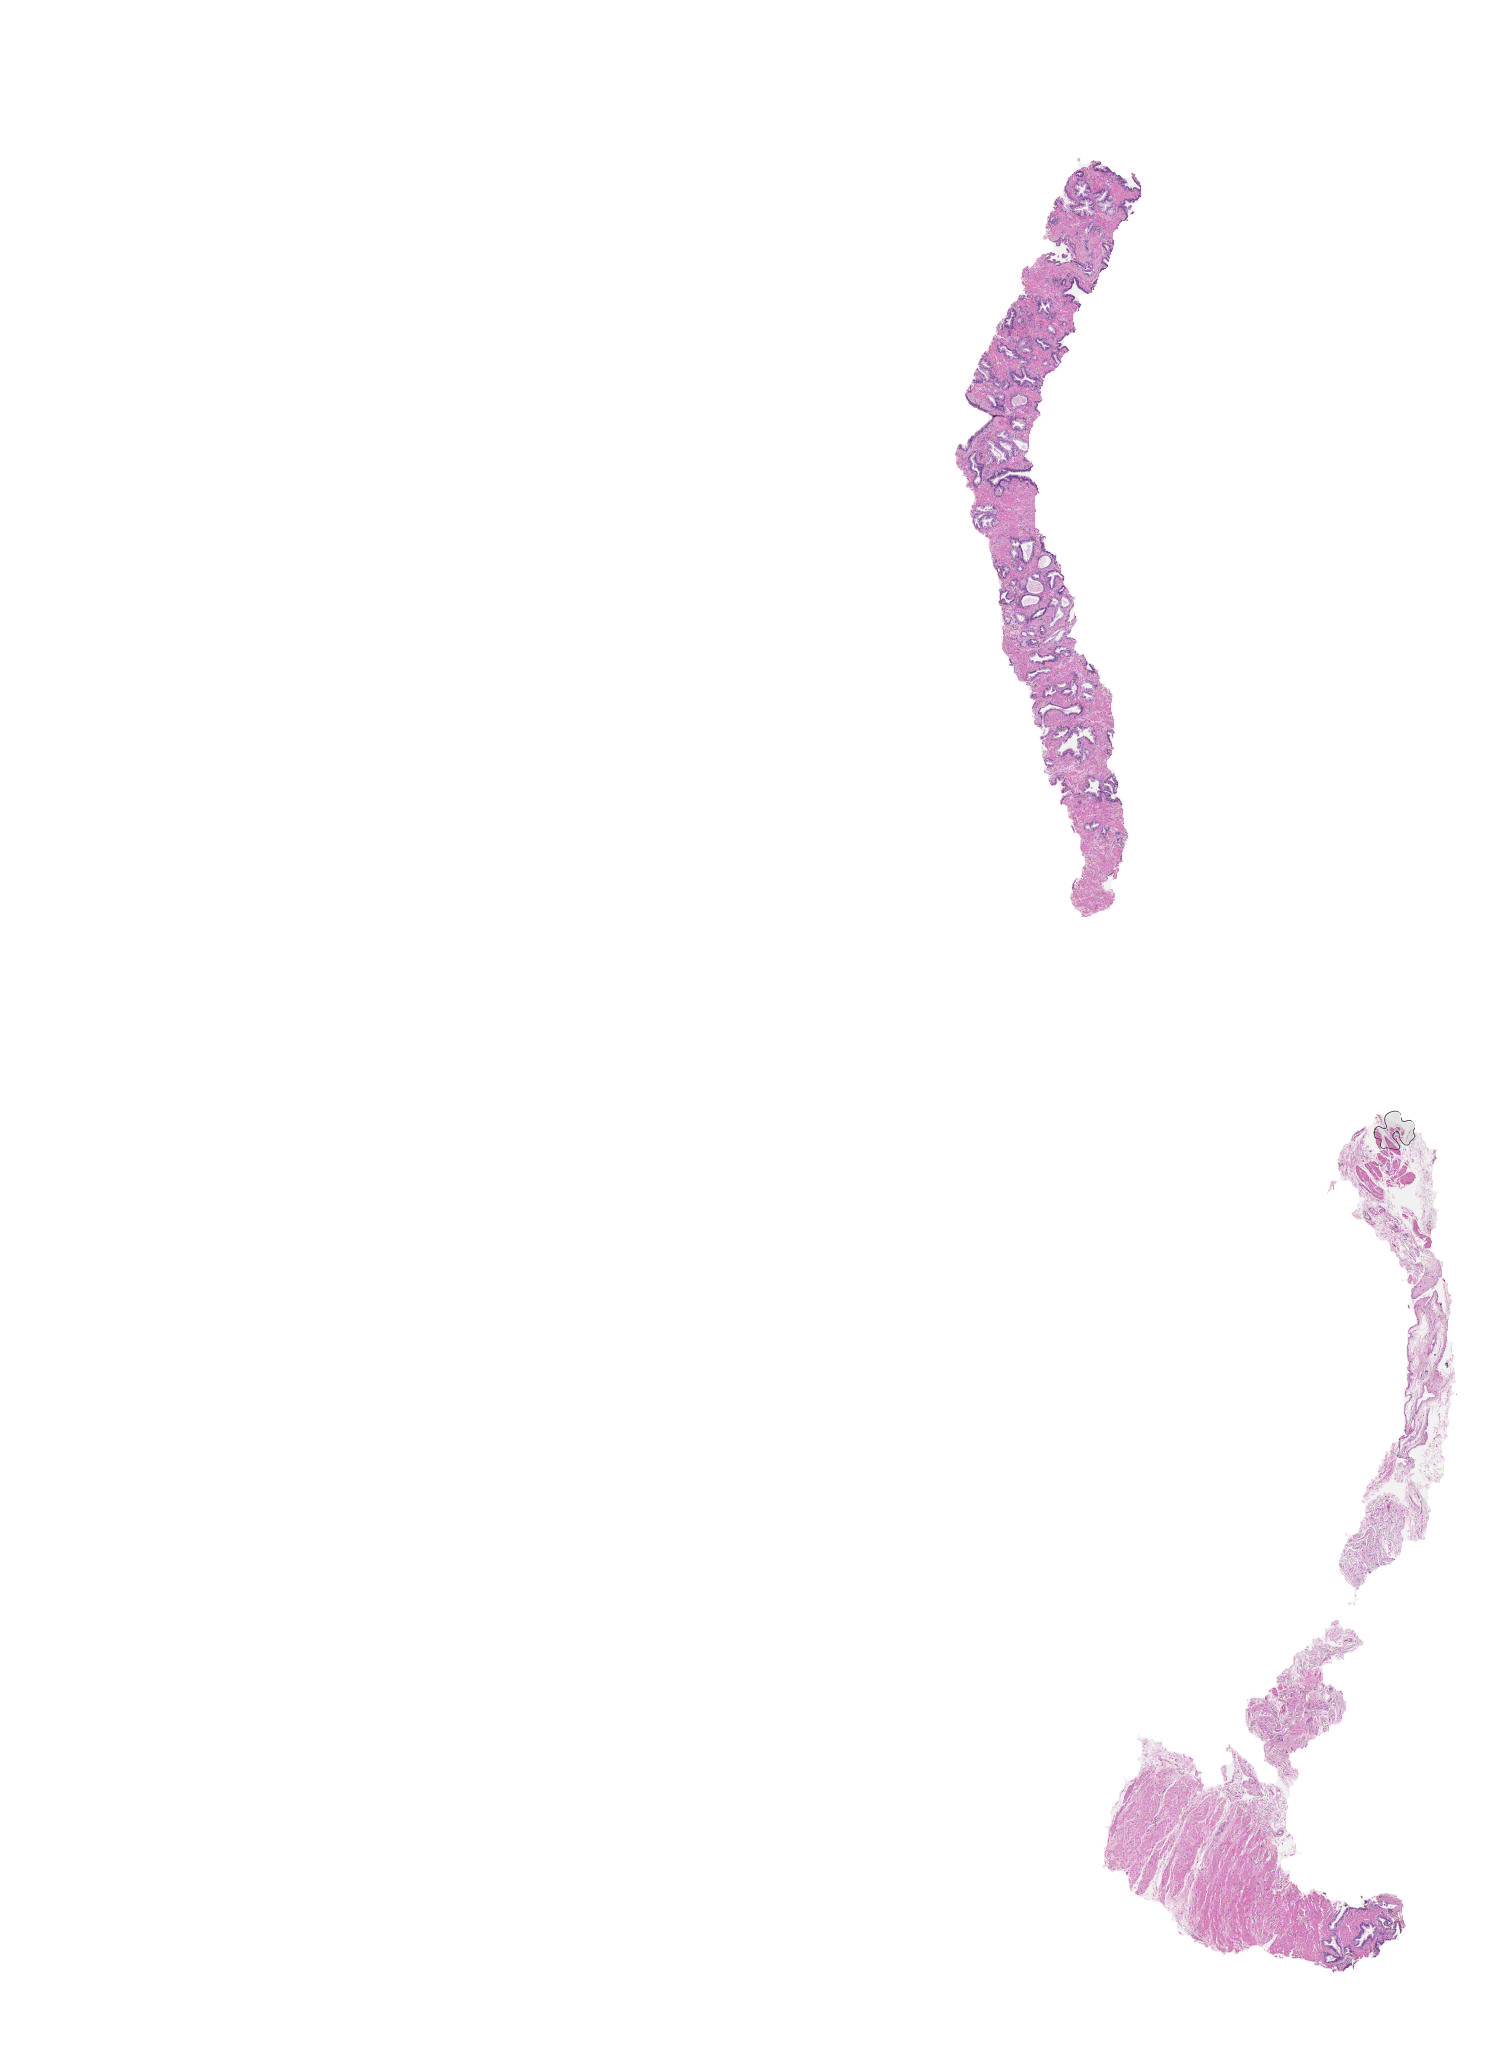

In [6]:
img = os.path.join(DATA_DIR, f'{train_df["image_id"].iloc[5]}.tiff')
img = openslide.OpenSlide(img)
patch = img.read_region((0, 0), 2, img.level_dimensions[-1])
img.close()
patch

Here are some constants' definition, which you can modify if you want higher dimensional images instead of 256x256 or you want to use higher resolution images.

In [7]:
crop_size = 256  # Size of resultant images
crop_level = 2  # The level of slide used to get the images (you can use 0 to get very high resolution images)
down_samples = [1, 4, 16]  # List of down samples available in any tiff image file

The below code will crop the given image and will store the result in an array

In [8]:
def split_image(openslide_image):
    """
    Splits the given image into multiple images if 256x256
    """
    
    # Get the size of the given image
    width, height = openslide_image.level_dimensions[crop_level]

    # Get the dimensions of level 0 resolution, as it's required in "read_region()" function
    base_height = down_samples[crop_level] * height  # height of level 0
    base_width = down_samples[crop_level] * width  # width of level 0

    # Get the number of smaller images 
    h_crops = math.ceil(width / crop_size)
    v_crops = math.ceil(height / crop_size)

    splits = []
    for v in range(v_crops):
        for h in range(h_crops): 
            x_location = h*crop_size*down_samples[crop_level]
            y_location = v*crop_size*down_samples[crop_level]

            patch = openslide_image.read_region((x_location, y_location), crop_level, (crop_size, crop_size))

            splits.append(patch)
    return splits, h_crops, v_crops

In [9]:
img = os.path.join(DATA_DIR, f'{train_df["image_id"].iloc[5]}.tiff')
img = openslide.OpenSlide(img)
crops, h_crops, v_crops = split_image(img)
img.close()

Now as we have all the smaller images available. Let's plot all of them and verify out result by comparing it to original image.

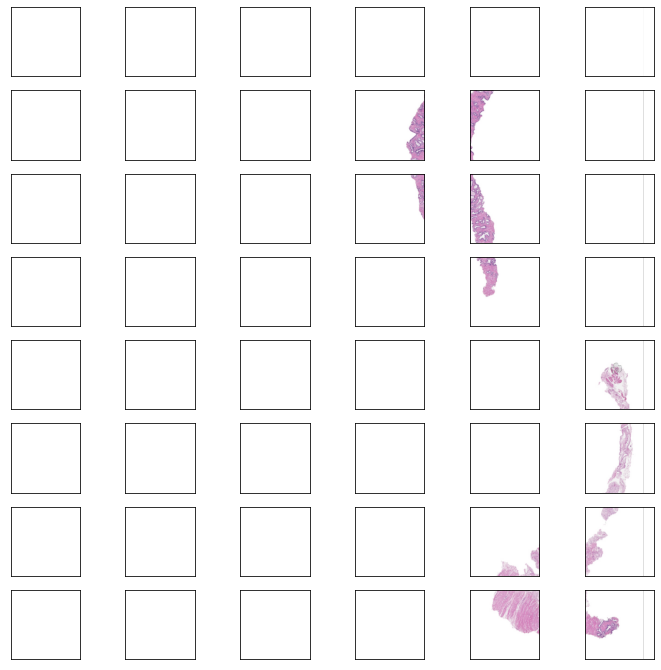

In [10]:
fig, ax = plt.subplots(nrows=v_crops, ncols=h_crops, figsize=(12, 12))
count=0
for row in ax:
    for col in row:
        patch = crops[count]
        col.grid(False)
        col.set_xticks([])
        col.set_yticks([])
        col.imshow(patch)
        count += 1
plt.show()

This looks promising. The only thing remaining is to discard the 'white' images. Let's do it.

In [11]:
def get_emptiness(arr):
    total_ele = arr.size
    white_ele = np.count_nonzero(arr == 255) + np.count_nonzero(arr == 0)
    return white_ele / total_ele

In [12]:
ignore_threshold = 0.95  # If the image is more than 95% empty, consider it as white and ignore

In [13]:
def filter_white_images(images):
    non_empty_crops = []
    for image in images:
        image_arr = np.array(image)[...,:3]  # Discard the alpha channel
        emptiness = get_emptiness(image_arr)
        if emptiness < ignore_threshold:
            non_empty_crops.append(image)
    return non_empty_crops

In [14]:
non_empty_crops = filter_white_images(crops)

In [15]:
len(non_empty_crops)

11

Let's plot all the crops separately and verify that all the crops have meaningful details and are not empty.

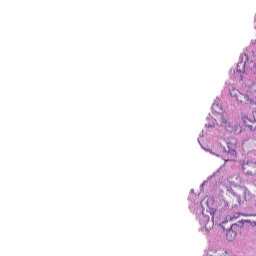

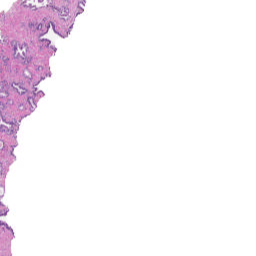

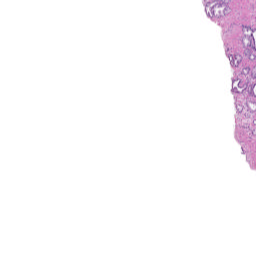

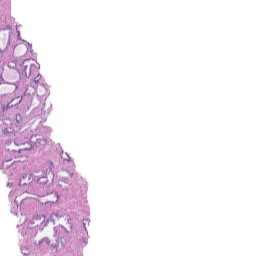

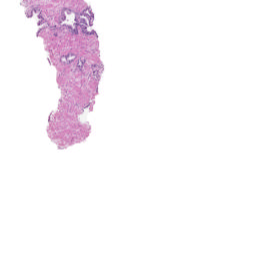

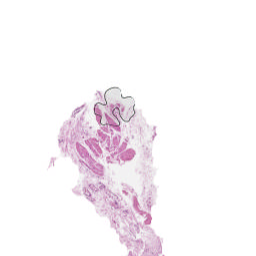

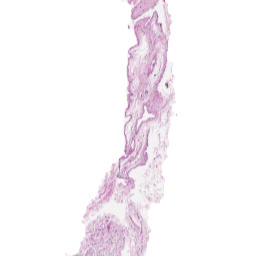

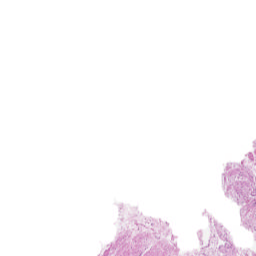

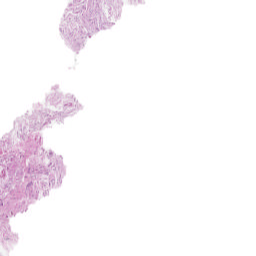

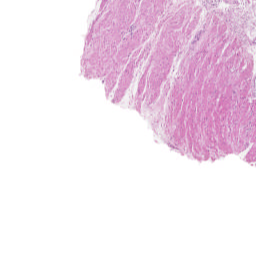

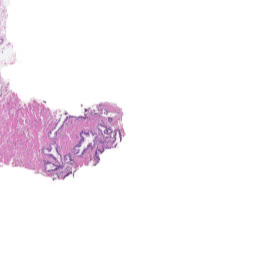

In [16]:
for f in non_empty_crops:
    display(f)

Cheers! We divided a large image into multiple images of size 256x256. Repeat this procedure on each of the training image to get the fixed sized images without lossing any data. 

Now let's do the above procedure for entire training dataset and save the resultant dataset so that it can be used further in training the models.

In [17]:
# train_df = train_df.loc[:20]

In [18]:
!mkdir train_images

In [19]:
dataset = []
def create_dataset(count):
    img = os.path.join(DATA_DIR, f'{train_df["image_id"].iloc[count]}.tiff')
    img = openslide.OpenSlide(img)
    crops, _, _ = split_image(img)
    img.close()

    non_empty_crops = filter_white_images(crops)
    image_id = train_df['image_id'].iloc[count]

    for index, img in enumerate(non_empty_crops):
        img_metadata = {}
        img = img.convert('RGB')

        img_metadata['image_id'] = f'{image_id}_{index}'
        img_metadata['data_provider'] = train_df['data_provider'].iloc[count]
        img_metadata['isup_grade'] = train_df['isup_grade'].iloc[count]
        img_metadata['gleason_score'] = train_df['gleason_score'].iloc[count]

        img.save(f'train_images/{image_id}_{index}.jpg', 'JPEG', quality=100, optimize=True, progressive=True)
        dataset.append(img_metadata)
    return dataset

In [20]:
dataset = Parallel(n_jobs=8)(delayed(create_dataset)(count) for count in tqdm(range(len(train_df))))
dataset = [item for sublist in dataset for item in sublist]

dataset = pd.DataFrame(dataset)

100%|██████████| 10616/10616 [23:47<00:00,  7.44it/s]


## Creating k-folds

In [21]:
dataset.loc[:, 'kfold'] = -1

# Randomly shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

X = dataset[['image_id', 'data_provider']].values
y = dataset[['isup_grade', 'gleason_score']].values

mskf = MultilabelStratifiedKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y)):
    dataset.loc[val_idx, 'kfold'] = fold

print(dataset.kfold.value_counts())

2    18486
1    18486
4    18485
3    18485
0    18485
Name: kfold, dtype: int64


In [22]:
dataset

,image_id,data_provider,isup_grade,gleason_score,kfold
0,1b04602fffd6117606d1a05efa96daaf_4,radboud,5,5+4,3
1,e2726cffee3499287c6f87b561dd228d_10,radboud,5,5+4,0
2,d908ac781e507048dca9b45d93fcec44_1,karolinska,3,4+3,4
3,56e5d931e0c46a942e76aaa95485b9cd_6,radboud,5,4+5,1
4,effe920ec2c4a10fe08d237a806d04d5_1,karolinska,0,0+0,0
...,...,...,...,...,...
92422,418e6b6e39af708710e1e497ca629ee8_3,radboud,3,4+3,3
92423,39f36065811dabb953b5fa41f826f669_6,radboud,5,4+5,4
92424,836e64bc05fc3ca33fcaae4102d1f989_4,karolinska,3,4+3,1
92425,0f7afae16aa8f61f8f1682665e53ef98_10,karolinska,3,4+3,2


In [23]:
dataset.to_csv('train.csv', index=False)

In [24]:
import zipfile
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('train.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/kaggle/working/train_images', zipf)
zipf.close()

In [25]:
!mv train.zip train

In [26]:
!rm -rf /kaggle/working/train_images

In [27]:
!ls

__notebook__.ipynb  train  train.csv
